In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots


In [3]:
# =========================
# Read + Train/Test split
# =========================
# Read the CSV file
df = pd.read_csv("admission.csv")

#Take the last 4 observations in each group as test data

test_df = (
    df.groupby("Group", group_keys=False) # do not keep the Group index
      .tail(4)
)

# Remaining observations as training data
train_df = df.drop(test_df.index)


C:\Users\soonm\AppData\Local\Temp\ipykernel_26924\4114749862.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(gpa_by_group, labels=[str(g) for g in groups], showmeans=True)
C:\Users\soonm\AppData\Local\Temp\ipykernel_26924\4114749862.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(gmat_by_group, labels=[str(g) for g in groups], showmeans=True)


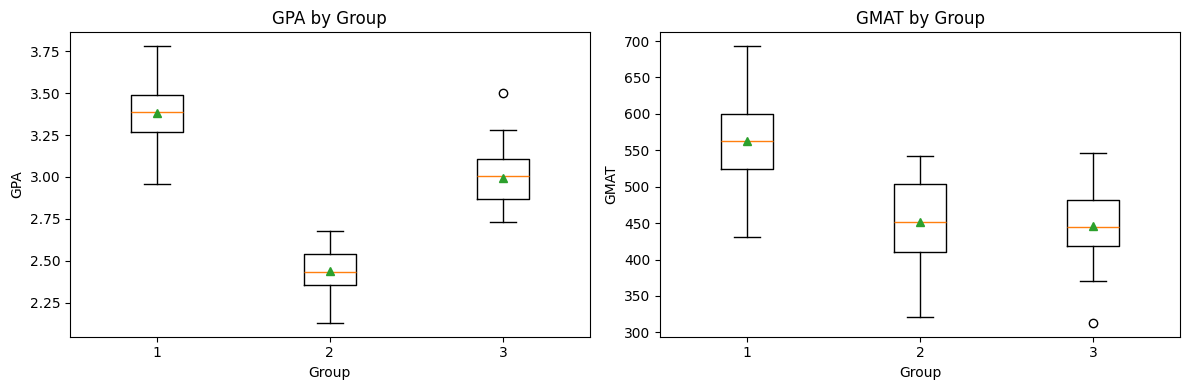

In [4]:
# =========================
# Question a-1) Box plots: GPA and GMAT by Group
# =========================
groups = [1, 2, 3]
gpa_by_group  = [train_df.loc[train_df["Group"] == g, "GPA"].dropna().values for g in groups]
gmat_by_group = [train_df.loc[train_df["Group"] == g, "GMAT"].dropna().values for g in groups]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axes[0].boxplot(gpa_by_group, labels=[str(g) for g in groups], showmeans=True)
axes[0].set_title("GPA by Group")
axes[0].set_xlabel("Group")
axes[0].set_ylabel("GPA")

axes[1].boxplot(gmat_by_group, labels=[str(g) for g in groups], showmeans=True)
axes[1].set_title("GMAT by Group")
axes[1].set_xlabel("Group")
axes[1].set_ylabel("GMAT")

plt.tight_layout()
plt.show()

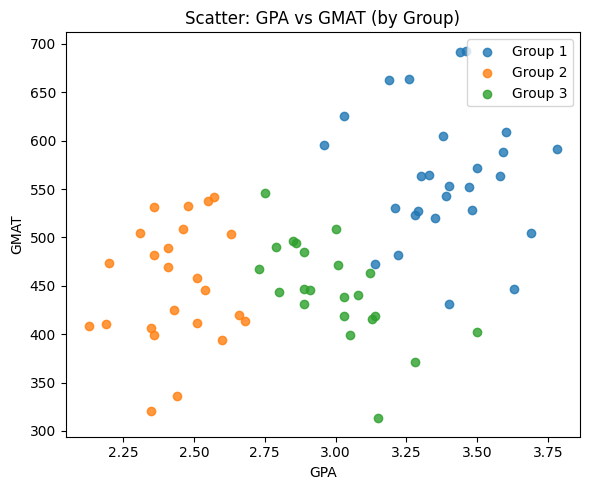

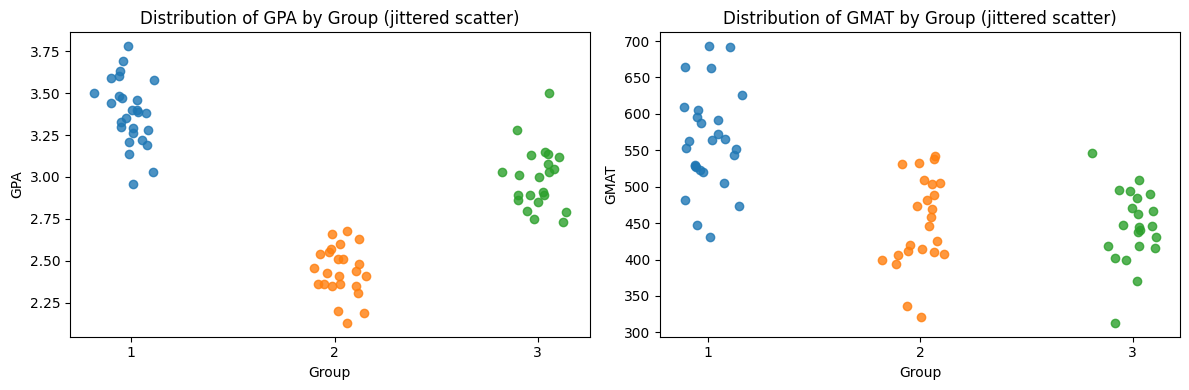

In [5]:
# =========================
# Question a-2) Scatter plots comparing Groups
# (A) GPA vs GMAT (colored by Group)
# (B) "1D scatter" (jitter) for each predictor vs Group
# =========================

# (A) GPA vs GMAT
fig, ax = plt.subplots(figsize=(6, 5))
for g in groups:
    sub = train_df[train_df["Group"] == g]
    ax.scatter(sub["GPA"], sub["GMAT"], alpha=0.8, label=f"Group {g}")

ax.set_title("Scatter: GPA vs GMAT (by Group)")
ax.set_xlabel("GPA")
ax.set_ylabel("GMAT")
ax.legend()
plt.tight_layout()
plt.show()

# (B) Jittered scatter for each predictor vs Group (helps compare distributions)
rng = np.random.default_rng(0)

def jitter(x, scale=0.08):
    return x + rng.normal(0, scale, size=len(x))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# GPA vs Group (with jitter on x)
for g in groups:
    vals = train_df.loc[train_df["Group"] == g, "GPA"].dropna().values
    axes[0].scatter(jitter(np.full_like(vals, g, dtype=float)), vals, alpha=0.8)
axes[0].set_title("Distribution of GPA by Group (jittered scatter)")
axes[0].set_xlabel("Group")
axes[0].set_ylabel("GPA")
axes[0].set_xticks(groups)
axes[0].set_xticklabels([str(g) for g in groups])

# GMAT vs Group (with jitter on x)
for g in groups:
    vals = train_df.loc[train_df["Group"] == g, "GMAT"].dropna().values
    axes[1].scatter(jitter(np.full_like(vals, g, dtype=float)), vals, alpha=0.8)
axes[1].set_title("Distribution of GMAT by Group (jittered scatter)")
axes[1].set_xlabel("Group")
axes[1].set_ylabel("GMAT")
axes[1].set_xticks(groups)
axes[1].set_xticklabels([str(g) for g in groups])

plt.tight_layout()
plt.show()

In [6]:
# =========================
# Question a-3) Correlation by Group
# =========================

corr_results = {}

for g in groups:
    sub = train_df.loc[train_df["Group"] == g, ["GPA", "GMAT"]].dropna()
    corr = sub["GPA"].corr(sub["GMAT"])   # Pearson correlation (default)
    corr_results[g] = corr
    print(f"Group {g}: Corr(GPA, GMAT) = {corr:.3f}")


Group 1: Corr(GPA, GMAT) = -0.078
Group 2: Corr(GPA, GMAT) = 0.139
Group 3: Corr(GPA, GMAT) = -0.655


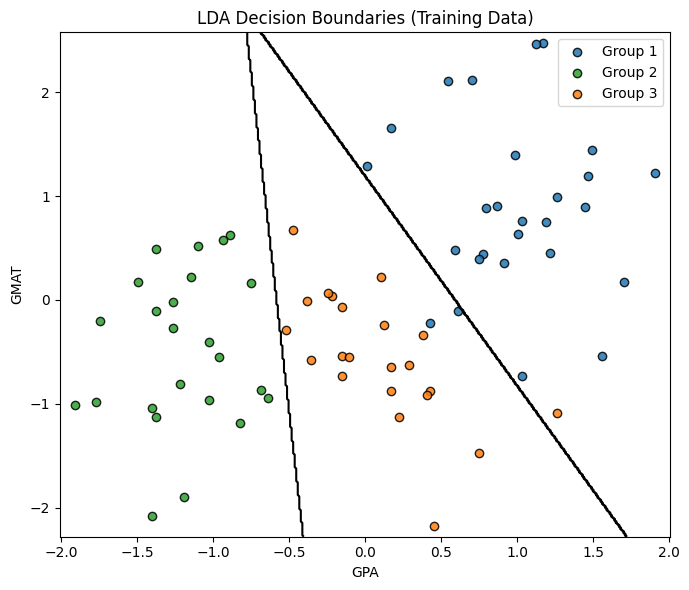

In [7]:
# =========================
# Question b) LDA
# =========================
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------
# Standardize predictors because the unit of measurements
# are very different between GPA and GMAT.
# ------------------------------------------------------
scaler = StandardScaler()

X_train = train_df[["GPA", "GMAT"]].to_numpy()
X_test  = test_df[["GPA", "GMAT"]].to_numpy()

# Fit ONLY on training data
X_train_std = scaler.fit_transform(X_train)

# Apply SAME transformation to test data
X_test_std = scaler.transform(X_test)

# -------------------------
# Prepare x and y
# -------------------------

y_train = train_df["Group"].to_numpy()
Xy_train = pd.DataFrame(
    X_train_std,
    columns=["GPA", "GMAT"]
)
Xy_train["Group"] = y_train



# -------------------------
# Fit LDA
# -------------------------
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_std, y_train)


# Grid limits
x_min, x_max = X_train_std[:, 0].min() - 0.1, X_train_std[:, 0].max() + 0.1
y_min, y_max = X_train_std[:, 1].min() - 0.1, X_train_std[:, 1].max() + 0.1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)

grid = np.c_[xx.ravel(), yy.ravel()]


lda_pred = lda.predict(grid)
lda_pred = lda_pred.reshape(xx.shape)


groups = [1, 2, 3]
colors = {1: "tab:blue", 2: "tab:green", 3: "tab:orange"}

#------------------------------------------------
# One Figure: Discrimination Contour + data points
#--------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

# Decision boundaries
ax.contour(
    xx, yy, lda_pred,
    levels=[1.5, 2.5],
    colors="black",
    linewidths=1.5
)

# Training points
for g in groups:
    sub = Xy_train[Xy_train["Group"] == g]
    plt.scatter(
        sub["GPA"], sub["GMAT"],
        color=colors[g],
        label=f"Group {g}",
        edgecolor="k",
        alpha=0.85
    )

ax.set_xlabel("GPA")
ax.set_ylabel("GMAT")
ax.set_title("LDA Decision Boundaries (Training Data)")
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
# -----------------------------------------------
# Prepare x and y for using standarzed test data
# ------------------------------------------------


y_test = test_df["Group"].to_numpy()
Xy_test = pd.DataFrame(
    X_test_std,
    columns=["GPA", "GMAT"]
)
Xy_test["Group"] = y_test


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
# -----------------------
# Predictions
#-------------------------

y_train_pred = lda.predict(X_train_std)
y_test_pred  = lda.predict(X_test_std)

# ------------------------
# Confusion Matrices
# -------------------------
labels = [1, 2, 3]

cm_train = confusion_matrix(y_train, y_train_pred, labels=labels)
cm_test  = confusion_matrix(y_test,  y_test_pred,  labels=labels)

cm_train_df = pd.DataFrame(
    cm_train,
    index=[f"True {g}" for g in labels],
    columns=[f"Pred {g}" for g in labels]
)

cm_test_df = pd.DataFrame(
    cm_test,
    index=[f"True {g}" for g in labels],
    columns=[f"Pred {g}" for g in labels]
)

print("Confusion Matrix — Training Data")
print(cm_train_df, "\n")

print("Confusion Matrix — Test Data")
print(cm_test_df, "\n")

# =========================
# Misclassification Rates
# =========================
train_misclass_rate = 1 - accuracy_score(y_train, y_train_pred)
test_misclass_rate  = 1 - accuracy_score(y_test,  y_test_pred)

print(f"Training misclassification rate: {train_misclass_rate:.3f}")
print(f"Test misclassification rate:     {test_misclass_rate:.3f}")


Confusion Matrix — Training Data
        Pred 1  Pred 2  Pred 3
True 1      25       0       2
True 2       0      24       0
True 3       1       0      21 

Confusion Matrix — Test Data
        Pred 1  Pred 2  Pred 3
True 1       3       0       1
True 2       0       2       2
True 3       0       0       4 

Training misclassification rate: 0.041
Test misclassification rate:     0.250


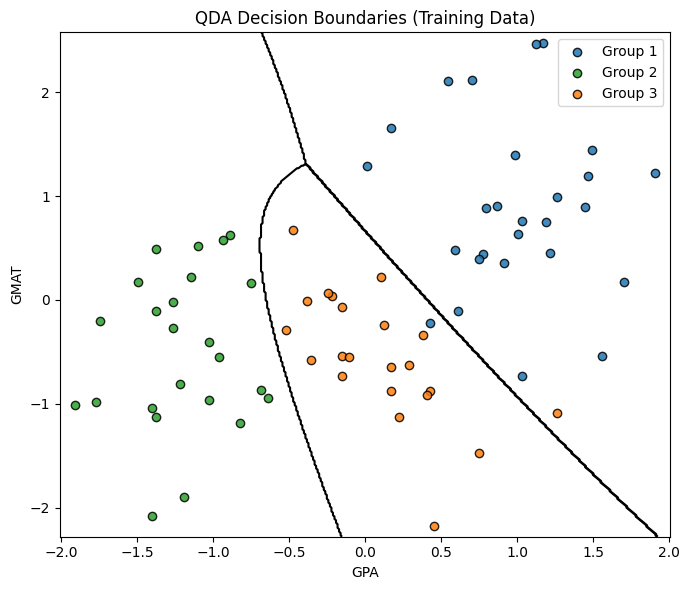

In [10]:
# =========================
# Question c)QDA
# =========================
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# ------------------------------------------------------
# Predictors were standardized in LDA because the unit of measurements
# are very different between GPA and GMAT.
# ------------------------------------------------------

# -------------------------
# Fit QDA
# -------------------------
qda = QDA()
qda.fit(X_train_std, y_train)

# Grid limits
x_min, x_max = X_train_std[:, 0].min() - 0.1, X_train_std[:, 0].max() + 0.1
y_min, y_max = X_train_std[:, 1].min() - 0.1, X_train_std[:, 1].max() + 0.1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)

grid = np.c_[xx.ravel(), yy.ravel()]
qda_pred = qda.predict(grid)
qda_pred = qda_pred.reshape(xx.shape)
groups = [1, 2, 3]
colors = {1: "tab:blue", 2: "tab:green", 3: "tab:orange"}

#---------------------------------------------------
# One Figure: Discrimination Contour + data points
#-------------------------------------------------- 
fig, ax = plt.subplots(figsize=(7, 6))

#---------------------
# Decision boundaries
#---------------------
ax.contour(    
    xx, yy, qda_pred,
    levels=[1.5, 2.5],
    colors="black",
    linewidths=1.5
)
#---------------------
# Training points
#---------------------
for g in groups:
    sub = Xy_train[Xy_train["Group"] == g]
    plt.scatter(
        sub["GPA"], sub["GMAT"],
        color=colors[g],
        label=f"Group {g}",
        edgecolor="k",
        alpha=0.85
    )

ax.set_xlabel("GPA")
ax.set_ylabel("GMAT")
ax.set_title("QDA Decision Boundaries (Training Data)")
ax.legend()
plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
# -----------------------
# Predictions
#-------------------------

yq_train_pred = qda.predict(X_train_std)
yq_test_pred  = qda.predict(X_test_std)

# ------------------------
# Confusion Matrices
# -------------------------
labels = [1, 2, 3]

cm_train = confusion_matrix(y_train, yq_train_pred, labels=labels)
cm_test  = confusion_matrix(y_test,  yq_test_pred,  labels=labels)

cm_train_df = pd.DataFrame(
    cm_train,
    index=[f"True {g}" for g in labels],
    columns=[f"Pred {g}" for g in labels]
)

cm_test_df = pd.DataFrame(
    cm_test,
    index=[f"True {g}" for g in labels],
    columns=[f"Pred {g}" for g in labels]
)

print("QDA Confusion Matrix — Training Data")
print(cm_train_df, "\n")

print("QDA Confusion Matrix — Test Data")
print(cm_test_df, "\n")

# =========================
# Misclassification Rates
# =========================
train_misclass_rate = 1 - accuracy_score(y_train, yq_train_pred)
test_misclass_rate  = 1 - accuracy_score(y_test,  yq_test_pred)

print(f"Training misclassification rate: {train_misclass_rate:.3f}")
print(f"Test misclassification rate:     {test_misclass_rate:.3f}")


QDA Confusion Matrix — Training Data
        Pred 1  Pred 2  Pred 3
True 1      26       0       1
True 2       0      24       0
True 3       1       0      21 

QDA Confusion Matrix — Test Data
        Pred 1  Pred 2  Pred 3
True 1       4       0       0
True 2       0       2       2
True 3       0       0       4 

Training misclassification rate: 0.027
Test misclassification rate:     0.167


In [12]:
# =========================
# Question d)KNN
# =========================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

test_errors = []
k_value =  range(1, 10, 1)
for k in k_value:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_std, y_train)     
    y_test_pred = knn.predict(X_test_std)
    test_error = 1 - accuracy_score(y_test, y_test_pred)    
    test_errors.append(test_error)

results = pd.DataFrame({
    "k": k_value,
    "test_error_rate": test_errors
})

k_best = results.loc[
    results["test_error_rate"].idxmin(), "k"
]

print(results)
print(f"\nOptimal k (min test error): {k_best}")


   k  test_error_rate
0  1         0.166667
1  2         0.083333
2  3         0.083333
3  4         0.083333
4  5         0.250000
5  6         0.083333
6  7         0.250000
7  8         0.250000
8  9         0.250000

Optimal k (min test error): 2


In [13]:
# =========================
# Question d) KNN. I chose k=3
# =========================
from sklearn.metrics import (    
    recall_score, #sensitivity
    confusion_matrix,
    roc_auc_score)


In [35]:
#----------------------
# Fit KNN with k = 3
#---------------------
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_std, y_train)


,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",3
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [37]:
#---------------------------------
#Predictions and probabilities
#------------------------------
y_train_pred = knn.predict(X_train_std)
y_train_prob = knn.predict_proba(X_train_std)


In [38]:
#--------------------------------
# Train_Error rate
#-------------------------------
train_error = 1 - accuracy_score(y_train, y_train_pred)
train_error

0.0273972602739726

In [39]:
#----------------------------
# Train_Sensitivity (macro-averaged)
#----------------------------
train_sensitivity = recall_score(
    y_train,
    y_train_pred,
    average="macro"
)
train_sensitivity

0.9696969696969697

In [40]:
#------------------------------
# Train_specificity
#------------------------------

cm = confusion_matrix(y_train, y_train_pred, labels=[1, 2, 3])

specificities = []

for i in range(len(cm)):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)
    specificity = TN / (TN + FP)
    specificities.append(specificity)

train_specificity = np.mean(specificities)
train_specificity

np.float64(0.9859509020999705)

In [41]:
#-----------------------------------
# Train_AUC (multiclass, one-vs-rest)
#------------------------------------
train_auc = roc_auc_score(
    y_train,
    y_train_prob,
    multi_class="ovr"
)
train_auc

0.9974047846338067

In [42]:
#---------------------------
# Estimated test error rate
#-----------------------------

y_test_pred = knn.predict(X_test_std)
test_error = 1 - accuracy_score(y_test, y_test_pred)
test_error

0.08333333333333337